In [2]:
%matplotlib inline

from scipy.odr import *
from scipy.stats import *
import numpy as np
import pandas as pd
import os
import time
import matplotlib.pyplot as plt
import ast
from multiprocessing import Pool

import scipy

from IPython import display
from matplotlib.patches import Rectangle

from sklearn.metrics import mean_squared_error
import json

import scipy.stats as st
from sklearn.metrics import r2_score


from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt

import copy

from sklearn.model_selection import LeaveOneOut, LeavePOut

from multiprocessing import Pool

import tensorflow as tf
import sklearn
import sklearn.metrics

# Used for graph export
from tensorflow.python.framework import graph_util
from tensorflow.python.framework import graph_io
from keras.models import load_model
from keras import backend as K

tf.__version__

Using TensorFlow backend.


'1.5.0'

In [80]:
# the data, split between train and test sets
dfAll = pd.read_pickle("PklData/df_blobs.pkl")
df_train = dfAll[dfAll.userID != 6]
df_test = dfAll[dfAll.userID == 6]
df_test = df_test.reset_index()
df_train = df_train.reset_index()
#Create InputMethod Column and fill it with Knuckel / Finger
def f(row):
    if row['TaskID'] < 17:
        #val = "Knuckle"
        val = 0
    elif row['TaskID'] >= 17:
        #val = "Finger"
        val = 1
    return val
df_train['InputMethod'] = df_train.apply(f, axis=1)
df_test['InputMethod'] = df_test.apply(f, axis=1)

In [95]:
df_train_label

0        0
1        0
2        0
3        0
4        0
5        0
6        0
7        0
8        0
9        0
10       0
11       0
12       0
13       0
14       0
15       0
16       0
17       0
18       0
19       0
20       0
21       0
22       0
23       0
24       0
25       0
26       0
27       0
28       0
29       0
        ..
58028    1
58029    1
58030    1
58031    1
58032    1
58033    1
58034    1
58035    1
58036    1
58037    1
58038    1
58039    1
58040    1
58041    1
58042    1
58043    1
58044    1
58045    1
58046    1
58047    1
58048    1
58049    1
58050    1
58051    1
58052    1
58053    1
58054    1
58055    1
58056    1
58057    1
Name: InputMethod, Length: 58058, dtype: int64

In [82]:
df_train_blobs = df_train.Blobs
df_test_blobs = df_test.Blobs

df_train_label = df_train.InputMethod
df_test_label = df_test.InputMethod

In [83]:
# convert class vectors to binary class matrices (one-hot notation)
num_classes = 2
y_train_one_hot = tf.keras.utils.to_categorical(df_train_label, num_classes)
y_test_one_hot = tf.keras.utils.to_categorical(df_test_label, num_classes)

array([[  1,   0,   0,   0,   2,   1,   0,   0,   0,   0],
       [  0,   1,   2,   0,   5,   7,   5,   1,   1,   2],
       [  0,   0,   2,   1,   4,   9,   4,   1,   4,   1],
       [  0,   0,   1,   2,  11,  16,   9,   2,   2,   2],
       [  0,   0,   2,   7,  19,  44,  18,   5,   2,   4],
       [  0,   1,   2,  10,  79, 186,  35,   7,   5,   0],
       [  0,   0,   1,  13, 106, 166,  31,   9,   2,   0],
       [  0,   0,   1,   5,  23,  31,   9,   2,   1,   0],
       [  0,   0,   2,   2,   9,  13,   2,   4,   1,   1],
       [  0,   1,   1,   1,   4,   7,   5,   2,   1,   1]], dtype=uint8)

Text(0.5,1,'Label for image 58028 is: 0')

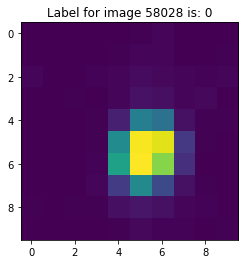

In [96]:
i = 58028
plt.imshow(df_train_blobs[i][0]) #np.sqrt(784) = 28
plt.title("Label for image %i is: %s" % (i, np.argmax(df_train_label[i])))

In [ ]:
# If GPU is not available: 
# GPU_USE = '/cpu:0'
# config = tf.ConfigProto(device_count = {"GPU": 0})


# If GPU is available: 
config = tf.ConfigProto()
config.log_device_placement = True
config.allow_soft_placement = True
config.gpu_options.allocator_type = 'BFC'

# Limit the maximum memory used
config.gpu_options.per_process_gpu_memory_fraction = 0.1

# set session config
tf.keras.backend.set_session(tf.Session(config=config))

In [ ]:
########## HYPER PARAMETERS
batch_size = 40
epochs = 100
optimizer = tf.keras.optimizers.RMSprop()
########## HYPER PARAMETERS

########## MODEL ARCHITECTURE
model = tf.keras.Sequential()

### OLD ARCHITECTURE START
#model.add(tf.keras.layers.Dense(5, activation='relu', input_shape=(784,)))
### OLD ARCHITECTURE END

### NEW CNN ARCHITECTURE
model.add(tf.keras.layers.Conv2D(20, kernel_size=(3, 3), activation='relu',padding='same', input_shape=(28,28,1)))
model.add(tf.keras.layers.Conv2D(20, kernel_size=(3, 3), activation='relu'))
model.add(tf.keras.layers.Conv2D(8, kernel_size=(3, 3), activation='relu'))
model.add(tf.keras.layers.Flatten())
### NEW CNN ARCHITECTURE

model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))
########## MODEL ARCHITECTURE

# Print summary
model.summary()

# compile model for training
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

history = model.fit(x_train, y_train_one_hot,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test_one_hot))

In [ ]:
# use model for inference to get test accuracy
y_test_pred = model.predict(x_test)
y_test_pred = np.argmax(y_test_pred, axis=1)

print ('\n Summary of the precision, recall, F1 score for each class:')
print (sklearn.metrics.classification_report(y_test, y_test_pred))

print ('\n Confusion matrix: ')
print (sklearn.metrics.confusion_matrix(y_test, y_test_pred))

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['val_acc'], label="Test Accuracy")
plt.plot(history.history['acc'], label="Training Accuracy")
plt.legend()

In [ ]:
# save model
model.save("myModel.h5")